# The purpose of this notebook is to demo tools for preparing data for a GLM

In [7]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

sys.path.append('/home/jovyan/workspace/SAP/feature_engineering')
import loss_ratio_univariate as lru

#create dummy pandas data for demo purposes
df = pd.DataFrame({'written_premium': np.random.uniform( 1000, 2000, 1000 ),
                   'ee': np.random.uniform( .9, 1, 1000 )})

df['incurred_loss'] = df['written_premium'] * np.random.uniform( .8, 1.02, 1000 )
df['earned_premium'] = df['written_premium'] * df['ee']

df['loss_ratio'] = df['incurred_loss'] / df['earned_premium']

# mock factors
df['covA_factor'] = ( df['written_premium'] / 1000 ) * np.random.uniform( .8, 1.1, 1000 )
df['covA'] =  df['covA_factor'] * np.log( df['written_premium'] ) * 100

df['adj_ep'] = df['earned_premium']  / df['covA_factor']
df['target'] = df['incurred_loss'] / df['adj_ep']


#bin the covA variable
df['covA_group_10'] = pd.cut( df['covA'], bins=10 )



In [18]:
df['covA'].describe()

count    1000.000000
mean     1055.731084
std       256.534759
min       566.492702
25%       834.462197
50%      1052.077687
75%      1248.452895
max      1645.077072
Name: covA, dtype: float64

# Linearizing a variable by grouping

The following function gives a way to compare and graphically identify various transformations of an independent variable

/home/jovyan/workspace/SAP/feature_engineering/loss_ratio_univariate.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_copy.groupby( variable ).agg( grouping_columns ).reset_index()


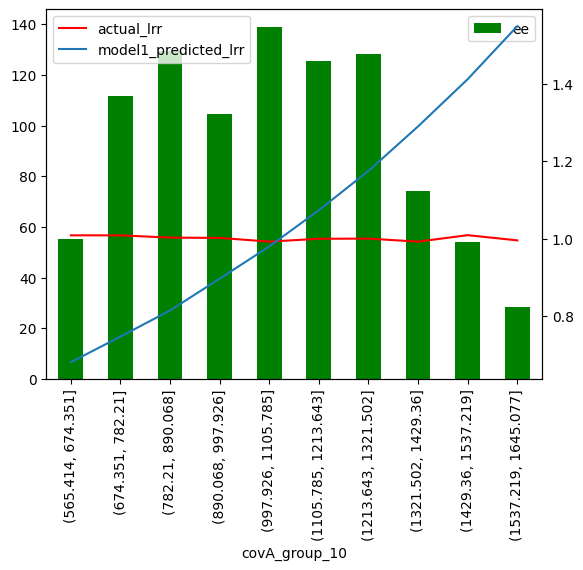

In [9]:
#build a tweedie model
glm_model1 = smf.glm(formula='target ~ covA', 
                     data=df, 
                     family=sm.families.Tweedie(var_power=1.5), 
                     freq_weights=np.asarray( df[ 'adj_ep' ] )
                     ).fit()

#build a tweedie model
df['covA2'] = df['covA'] - np.random.uniform( 0, 100, 1000 )
glm_model2 = smf.glm(formula='target ~ covA2', 
                    data=df, 
                    family=sm.families.Tweedie(var_power=1.5), 
                    freq_weights=np.asarray( df[ 'adj_ep' ] )
                    ).fit()


#plot one GLMs
_ = lru.var_chart( df, 'covA_group_10', {'model1': glm_model1}, 'incurred_loss', 'earned_premium', 'ee' )


This function also works with multiple models, and can return the graph data: 

/home/jovyan/workspace/SAP/feature_engineering/loss_ratio_univariate.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_copy.groupby( variable ).agg( grouping_columns ).reset_index()


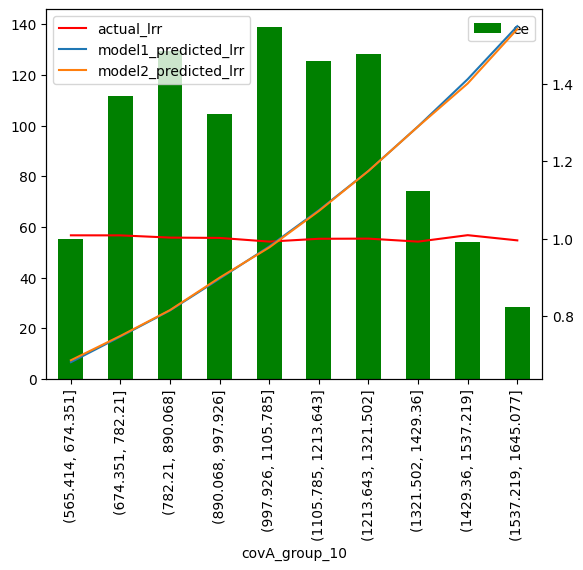

,covA_group_10,incurred_loss,earned_premium,ee,model1_predicted_ep,model2_predicted_ep,model1_predicted_lr,model1_predicted_lrr,model2_predicted_lr,model2_predicted_lrr,actual_lr,actual_lrr
0,"(565.414, 674.351]",55823.783471,57651.102243,55.083004,59914.670081,59482.930511,0.931721,0.680251,0.938484,0.685186,0.968304,1.008436
1,"(674.351, 782.21]",122813.246666,126848.574660,111.502679,120115.121163,119831.381379,1.022463,0.746501,1.024884,0.748266,0.968188,1.008315
2,"(782.21, 890.068]",154089.365070,160066.423679,129.317718,138182.719459,138027.166566,1.115113,0.814145,1.116370,0.815060,0.962659,1.002557
3,"(890.068, 997.926]",139856.518315,145405.279112,104.671429,113914.628291,113581.884448,1.227731,0.896367,1.231328,0.898990,0.961839,1.001703
4,"(997.926, 1105.785]",202166.947403,212200.192050,138.924944,150658.985634,151056.168709,1.341884,0.979711,1.338356,0.977131,0.952718,0.992204
5,"(1105.785, 1213.643]",201681.061619,210140.876340,125.515428,137169.785395,137417.568049,1.470302,1.073469,1.467651,1.071530,0.959742,0.999519
6,"(1213.643, 1321.502]",219115.078396,228223.067448,128.444115,136128.640851,136140.106743,1.609618,1.175183,1.609482,1.175080,0.960092,0.999883
7,"(1321.502, 1429.36]",129254.472069,135677.435934,74.172677,73136.899889,73151.192908,1.767295,1.290303,1.766950,1.290047,0.952660,0.992144
8,"(1429.36, 1537.219]",99456.920364,102671.800997,54.179252,51410.170115,51818.319240,1.934577,1.412436,1.919339,1.401306,0.968688,1.008836
9,"(1537.219, 1645.077]",53257.949380,55722.703148,28.520000,25093.414557,25214.774950,2.122387,1.549557,2.112172,1.542093,0.955768,0.995380


In [11]:
#plot two GLMs
lru.var_chart( df, 'covA_group_10', {'model1': glm_model1, 'model2': glm_model2}, 'incurred_loss', 'earned_premium', 'ee' )


## Other bivariates

Another way to plot bivaraites is to use something tlike the following 

